# Breast Cancer Classification.

Wisconsin Breast Cancer dataset (cancer, for short) records clinical measurements of breast cancer tumors. Each tumor is labeled as “benign” (for harmless tumors) or “malignant” (for cancerous tumors), and the task is to learn to predict whether a tumor is malignant based on the measurements of the tissue.

### Loading the dataset and exploring the data.

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print("cancer.keys(): \n{}".format(cancer.keys()))

cancer.keys(): 
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [3]:
print("Shape of cancer data: {}".format(cancer.data.shape))

Shape of cancer data: (569, 30)


In [58]:
# Printing out how many cancers were malignant and how many were benign.
import numpy as np

print("Sample counts per class:\n{}".format(
    {n: v for n, v in zip(cancer.target_names, np.bincount(cancer.target))}))

Sample counts per class:
{'malignant': 212, 'benign': 357}


In [7]:
# Looking at all the features that were recorded.
print("Feature names:\n{}".format(cancer.feature_names))

Feature names:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### Training a k-neighbors classifier.

For each test point, we count how many neighbors belong to class 0 and how many neighbors belong to class 1. We then assign the class that is more frequent: in other words, the majority class among the k-nearest neighbors.

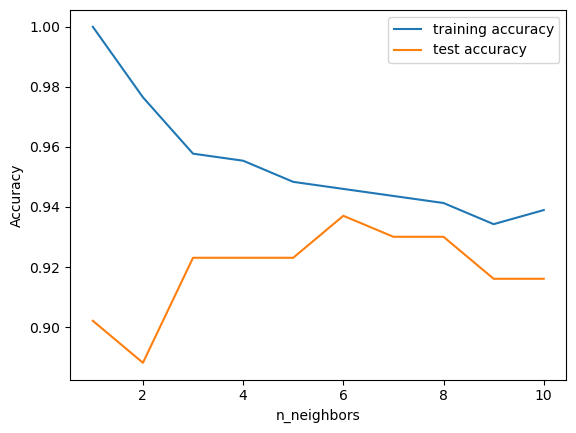

In [59]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(
        cancer.data, cancer.target, stratify=cancer.target, random_state=66)

training_accuracy = [] 
test_accuracy = []

# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(X_train, y_train)
    # record training set accuracy 
    training_accuracy.append(clf.score(X_train, y_train)) 
    # record generalization accuracy 
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the model becomes simpler and the training accuracy drops. The test set accuracy for using a single neighbor is lower than when using more neighbors, indicating that using the single nearest neighbor leads to a model that is too complex. On the other hand, when considering 10 neighbors, the model is too simple and performance is even worse. The best performance is somewhere in the middle, using around six neighbors.

**The nearest k-neighbors algorithm is easy to understand but it is not often used in practice, due to prediction being slow and its inability to handle many features.**

### Training Logistic Regression.
For LogisticRegression and LinearSVC the trade-off parameter that determines the strength of the regularization is called C, and higher values of C correspond to less regularization.

In [22]:
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, random_state=42) 
logreg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train))) 
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.958
Test set score: 0.958


The default value of C=1 provides quite good performance, with 95% accuracy on both the training and the test set. But as training and test set performance are very close, it is likely that we are underfitting. Let’s try to increase C to fit a more flexible model.

In [26]:
logreg100 = LogisticRegression(C=100, max_iter = 7000).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg100.score(X_train, y_train))) 
print("Test set score: {:.3f}".format(logreg100.score(X_test, y_test)))

Training set score: 0.984
Test set score: 0.965


Using C=100 results in higher training set accuracy, and also a slightly increased test set accuracy, confirming our intuition that a more complex model should perform better. We can also investigate what happens if we use an even more regularized model than the default of C=1, by setting C=0.01.

In [60]:
logreg001 = LogisticRegression(C=0.01, max_iter=500).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg001.score(X_train, y_train))) 
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

Training set score: 0.960
Test set score: 0.937


**Looking at coefficients learned by the three models.**

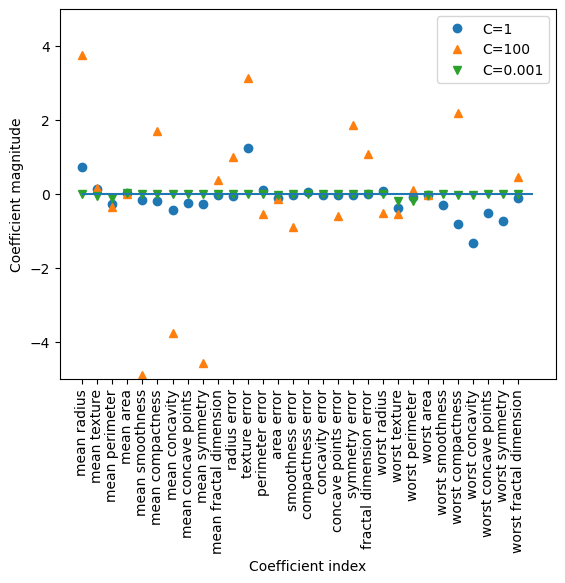

In [61]:
plt.plot(logreg.coef_.T, 'o', label="C=1")
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
plt.hlines(0, 0, cancer.data.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()

**Logistic regression applies an L2 regularization by default. Stronger regularization pushes coefficients more and more toward zero, though coefficients never become exactly zero. If we desire a more interpretable model, using L1 regularization might help, as it limits the model to using only a few features.**

Training accuracy of l1 logreg with C=0.001: 0.92
Test accuracy of l1 logreg with C=0.001: 0.90
Training accuracy of l1 logreg with C=1.000: 0.97
Test accuracy of l1 logreg with C=1.000: 0.94
Training accuracy of l1 logreg with C=100.000: 1.00
Test accuracy of l1 logreg with C=100.000: 0.97


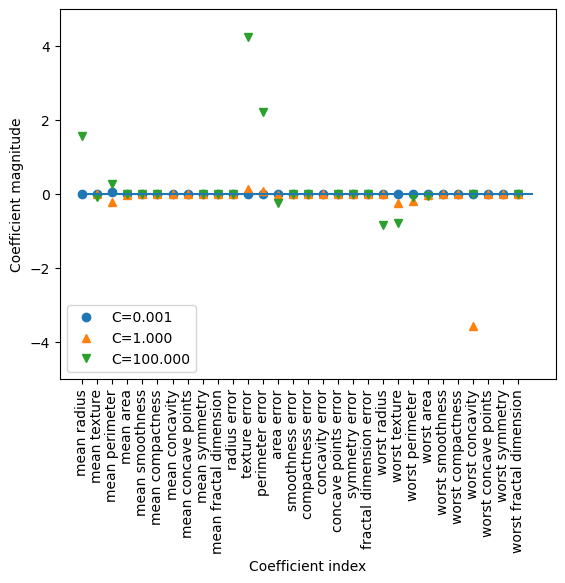

In [62]:
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(C=C, penalty="l1", max_iter=2000, solver='liblinear').fit(X_train, y_train) 
    print("Training accuracy of l1 logreg with C={:.3f}: {:.2f}".format(C, lr_l1.score(X_train, y_train)))
    print("Test accuracy of l1 logreg with C={:.3f}: {:.2f}".format(C, lr_l1.score(X_test, y_test)))
    plt.plot(lr_l1.coef_.T, marker, label="C={:.3f}".format(C))
    
plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
plt.hlines(0, 0, cancer.data.shape[1])
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.ylim(-5, 5)
plt.legend(loc=3)

### Training a decision tree classifier.

Decision trees are widely used models for classification and regression tasks. Essentially, they learn a hierarchy of if/else questions, leading to a decision.

In [32]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


There are two common strategies to prevent overfitting: stopping the creation of the tree early (also called pre-pruning), or building the tree but then removing or collapsing nodes that contain little information (also called post-pruning or just pruning). **Possible criteria for pre-pruning include limiting the maximum depth of the tree, limiting the maximum number of leaves**, or requiring a minimum number of points in a node to keep splitting it.

In [63]:
# after setting a maximum depth to avoid overfitting.
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.902


In [37]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


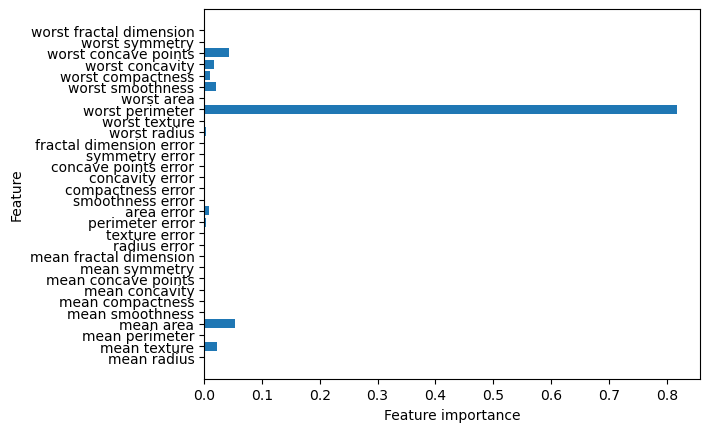

In [64]:
## plotting the importance of features as learned by the ML model.
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), cancer.feature_names) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(tree)

If a feature has a low feature_importance, it doesn’t mean that this feature is uninformative. It only means that the feature was not picked by the tree, likely because another feature encodes the same information.

### Training a random forest classifier.

A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results. 

In [39]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
        cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


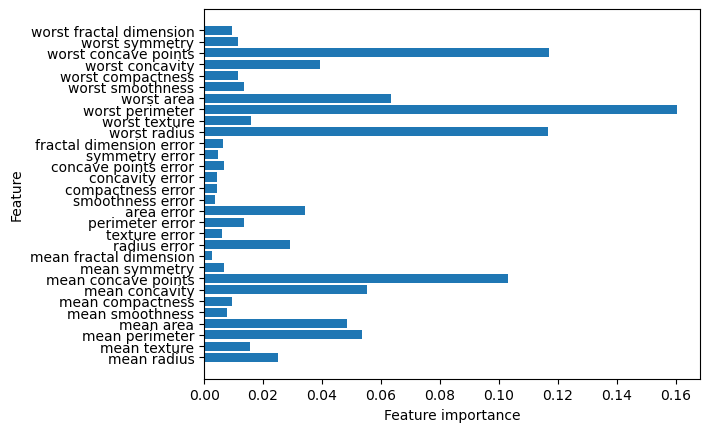

In [40]:
plot_feature_importances_cancer(forest)

### Training a gradient boosted classifier.

In [41]:
from sklearn.ensemble import GradientBoostingClassifier 

X_train, X_test, y_train, y_test = train_test_split(
        cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


In [42]:
# with a max depth of 1.
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [65]:
# with a different learning rate.
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.993
Accuracy on test set: 0.937


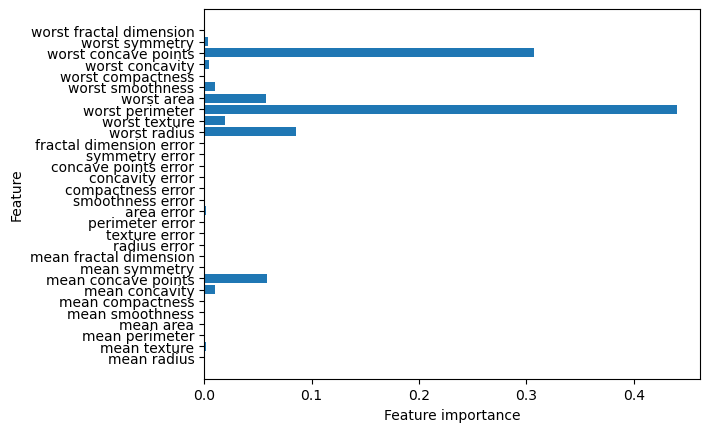

In [66]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
plot_feature_importances_cancer(gbrt)

### Training a linear support vector classifier.

In [46]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
    
svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train))) 
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.90
Accuracy on test set: 0.94


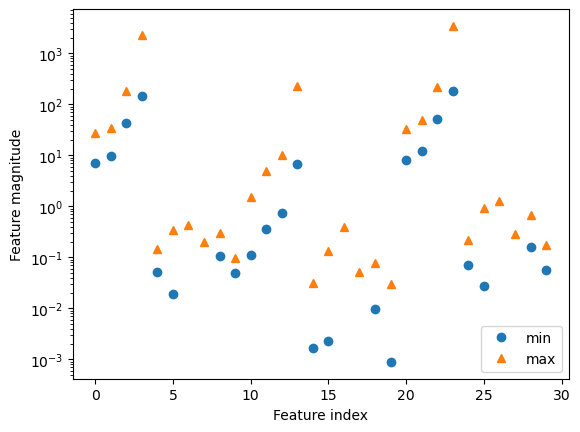

In [67]:
## plotting the magnitude of the features.
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

From this plot we can determine that features in the Breast Cancer dataset are of completely different orders of magnitude. This can be somewhat of a problem for other models (like linear models), but it has devastating effects for the kernel SVM.

In [68]:
# preprocessing the data for SVMs.

# compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)

# compute the range of each feature (max - min) on the training set 
range_on_training = (X_train - min_on_training).max(axis=0)

# subtract the min, and divide by range
# afterward, min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training 

print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0))) 
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [69]:
# use THE SAME transformation on the test set,
# using min and range of the training set (see Chapter 3 for details) 
X_test_scaled = (X_test - min_on_training) / range_on_training

In [70]:
svc = SVC()
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format( svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.986
Accuracy on test set: 0.972


In [71]:
# fitting a more complex model.
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format( svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


### Training a neural network classifier.

In [52]:
print("Cancer data per-feature maxima:\n{}".format(cancer.data.max(axis=0)))


Cancer data per-feature maxima:
[2.811e+01 3.928e+01 1.885e+02 2.501e+03 1.634e-01 3.454e-01 4.268e-01
 2.012e-01 3.040e-01 9.744e-02 2.873e+00 4.885e+00 2.198e+01 5.422e+02
 3.113e-02 1.354e-01 3.960e-01 5.279e-02 7.895e-02 2.984e-02 3.604e+01
 4.954e+01 2.512e+02 4.254e+03 2.226e-01 1.058e+00 1.252e+00 2.910e-01
 6.638e-01 2.075e-01]


In [53]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(
        cancer.data, cancer.target, random_state=0)

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train))) 
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 0.94
Accuracy on test set: 0.92


In [72]:
## scaling the data.

# compute the mean value per feature on the training set
mean_on_train = X_train.mean(axis=0)
# compute the standard deviation of each feature on the training set 
std_on_train = X_train.std(axis=0)

# subtract the mean, and scale by inverse standard deviation
# afterward, mean=0 and std=1
X_train_scaled = (X_train - mean_on_train) / std_on_train

# use THE SAME transformation (using training mean and std) on the test set 
X_test_scaled = (X_test - mean_on_train) / std_on_train
    
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format( mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.951


/Users/ellietripathi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [73]:
mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format( mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.958


In [74]:
# adding stronger regularization.
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format( mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


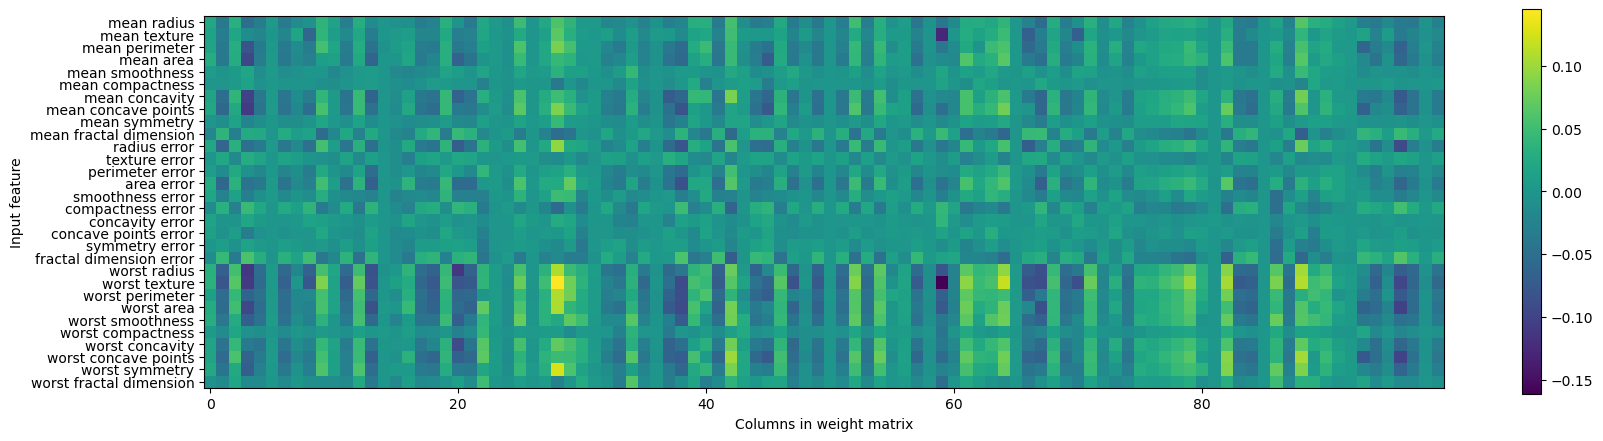

In [75]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()